In [1]:
import os, joblib, json, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random

In [2]:
#load the saved preprocessed data

project_root = os.path.abspath(os.path.join(os.getcwd()))
processed_path = os.path.join(project_root, "Data", "Processed")

x_train = joblib.load(os.path.join(processed_path, "train_scaled.pkl"))
x_val = joblib.load(os.path.join(processed_path, "val_scaled.pkl"))
x_test = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
y_test = joblib.load(os.path.join(processed_path, "test_labels.pkl"))


x_train.shape, x_val.shape, x_test.shape

((1638568, 50), (409643, 50), (834347, 50))

In [3]:
# load scaler so that any new 
# traffic data (later) will be scaled 
# the exact same way as the trained data

scaler_path = os.path.join(processed_path, "scaler_cicids.pkl")

if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
else:
    scaler = None
    print("scaler not found")


In [4]:
# BUILD THE AUTOENCODER

# ensure same results every time
seed = 55
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



input_dim = 50  # one input neuron for each feature

input_layer = Input(shape=(input_dim,), name="ae_input")   #entry point

# ENCODER (compression)
enc = Dense(32, activation='relu' , name="enc_dense_32")(input_layer)    
enc = Dense(16, activation='relu' , name="enc_dense_16")(enc)
enc = Dense(12, activation='relu' , name="enc_dense_12")(enc)
bottleneck = Dense(16, activation='relu' , name="bottleneck_16")(enc)
# each layer takes the previous layer's output and transforms it to a smaller number of neurons
# ,this compresses the information
# ,the final layer is the compressed version the encoder learns to use for reconstructing the data


# DECODER (reconstruction)
dec = Dense(12, activation='relu' , name="dec_dense_12")(bottleneck)
dec = Dense(16, activation='relu', name="dec_dense_16")(dec)
dec = Dense(32, activation='relu', name="dec_dense_32")(dec)

# these layers start reconstructing the data back to the original 50 dimension
# basically the encoder extracts patterns, decoder just rebuilds

output_layer = Dense(input_dim, activation='linear', name="ae_output")(dec)


autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

autoencoder.summary()


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_32 (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_16 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_12 (Dense)            │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_16 (Dense)           │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_12 (Dense)            │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_16 (Dense)            │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_32 (Dense)            │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_output (Dense)               │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,178 (20.23 KB)

 Trainable params: 5,178 (20.23 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# TRAIN THE AUTOENCODER

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    x_train, x_train,       # input = output bec autoencoder tries to reconstruct
    epochs=200,              # number of times the model sees all data
    batch_size=256,
    validation_data=(x_val, x_val),  #check reconstruction on validation set (no attacks)
    callbacks=[early_stop],
    verbose=1
    # shuffle=False
)


Epoch 1/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.1847 - val_loss: 0.0715
Epoch 2/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0572 - val_loss: 0.0475
Epoch 3/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0427 - val_loss: 0.0391
Epoch 4/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0365 - val_loss: 0.0342
Epoch 5/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0324 - val_loss: 0.0307
Epoch 6/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0293 - val_loss: 0.0281
Epoch 7/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0270 - val_loss: 0.0260
Epoch 8/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0250 - val_loss: 0.0242
Epoch 9/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0234 - val_loss: 0.0227
Epoch 10/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0220 - val_loss: 0.0215
Epoch 11/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0210 - val_loss: 0.0206
Epoch 12/200
6401/

In [6]:
# reconstruction error = how much the autoencoder failed to recreate the input

# get reconstructed outputs
train_pred = autoencoder.predict(x_train)
val_pred = autoencoder.predict(x_val)

# compute reconstruction error
train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse = np.mean(np.square(x_val - val_pred), axis=1)


51206/51206 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step
12802/12802 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [7]:
# test on traffic with anomalies
# low error = normal behavior it understands
# high error = unusual behavior = anomaly

test_pred = autoencoder.predict(x_test)     # get reconstructed output of x+test

test_mse = np.mean(np.square(x_test - test_pred), axis=1)

train_mse[:10] , test_mse[:10]   #just to see examples

26074/26074 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step


(array([0.00024352, 0.0251422 , 0.00408921, 0.00058571, 0.02001495,
        0.00514625, 0.00268333, 0.00113993, 0.04336171, 0.00125575]),
 array([0.0002007 , 0.00103877, 0.00027409, 0.00017998, 0.00428127,
        0.00027761, 0.00042772, 0.01397311, 0.0002904 , 0.00290323]))

In [8]:
# set anomaly threshold 
# and decide which reconstruction errors indicate anomalies
# We want to decide which error value counts as an anomaly.


best_threshold = np.percentile(val_mse, 88)  # top % of reconstruction error

print("Best threshold:", best_threshold)
# print("Best F1:", best_f1)




Best threshold: 0.017731424796764296


In [9]:
y_pred = (test_mse > best_threshold).astype(int)
print("Number of anomalies detected:", np.sum(y_pred))
print("Actual number of anomalies:", np.sum(y_test))


Number of anomalies detected: 464402
Actual number of anomalies: 424704.0


In [10]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)     #how many of the detected anomalies were actually attacks
print("Recall: ", recall)           #how many actual attacks were caught
print("F1-score; ", f1)
print("Confusion matrix:\n", cm)

Accuracy:  0.92974385956922
Precision:  0.8941477426884467
Recall:  0.9777256630500302
F1-score;  0.9340708531941073
Confusion matrix:
 [[360485  49158]
 [  9460 415244]]


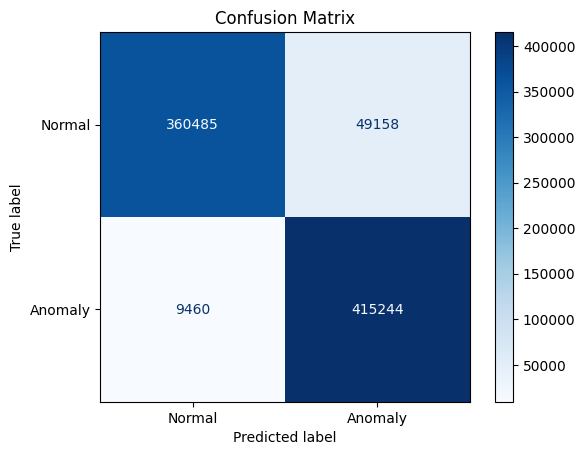

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()


In [12]:
# import joblib
# import os

# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# models_path = os.path.join(project_root, "Models")
# os.makedirs(models_path, exist_ok=True)

# joblib.dump(autoencoder, os.path.join(models_path, "autoencoder.pkl"))
# joblib.dump(best_threshold, os.path.join(models_path, "ae_threshold.pkl"))


In [13]:
import numpy as np
import joblib
import os

project_root = os.path.abspath(os.path.join(os.getcwd()))
models_path = os.path.join(project_root, "Models")
os.makedirs(models_path, exist_ok=True)

X_test_recon = autoencoder.predict(x_test, verbose=0)


recon_error = np.mean(
    np.square(x_test - X_test_recon),
    axis=1
)


joblib.dump(
    recon_error,
    os.path.join(models_path, "ae_preds.pkl")  
)

joblib.dump(
    best_threshold,
    os.path.join(models_path, "ae_threshold.pkl")
)


autoencoder.save(
    os.path.join(models_path, "autoencoder.keras")
)


train_pred = autoencoder.predict(x_train, verbose=0)
val_pred   = autoencoder.predict(x_val, verbose=0)

train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse   = np.mean(np.square(x_val - val_pred), axis=1)


joblib.dump(train_mse, os.path.join(models_path, "ae_train_scores.pkl"))
joblib.dump(val_mse, os.path.join(models_path, "ae_val_scores.pkl"))

['c:\\Users\\Nourhan\\Documents\\Graduation Project\\AI_Cybersecurity-main\\Models\\ae_val_scores.pkl']